Modules
==============================

In [18]:
using Tullio
using PyPlot
using BenchmarkTools
using ProgressMeter
using LinearAlgebra
using FFTW
FFTW.set_num_threads(Threads.nthreads())

using CMBLensing
import CMBLensing: Map, AzFourier, QUAzFourier, QUMap, m_fft, m_rfft, m_irfft,  m_ifft
using CirculantCov: βcovSpin2, βcovSpin0, geoβ,
multPP̄, multPP, periodize, Jperm # https://github.com/EthanAnderes/CirculantCov.jl

# LATER: remove LBblock dependence
using LBblocks: @sblock # https://github.com/EthanAnderes/LBblocks.jl

hide_plots = false

false

Methods ...
=======================================

In [25]:
function AzFourier(f::EquiRectMap)
    nφ = f.Nx
    EquiRectAzFourier(m_rfft(f.arr, 2) ./ √nφ, f.metadata)
end

function Map(f::EquiRectAzFourier)
    nφ = f.Nx
    EquiRectMap(m_irfft(f.arr, nφ, 2) .* √nφ, f.metadata)
end

function QUAzFourier(f::EquiRectQUMap)
    nθ, nφ = f.Ny, f.Nx
    Uf = m_fft(f.arr, 2) ./ √nφ
    f▫ = similar(Uf, 2nθ, nφ÷2+1)
    for ℓ = 1:nφ÷2+1
        if (ℓ==1) | ((ℓ==nφ÷2+1) & iseven(nφ))
            f▫[1:nθ, ℓ]     .= Uf[:,ℓ]
            f▫[nθ+1:2nθ, ℓ] .= conj.(Uf[:,ℓ])
        else
            f▫[1:nθ, ℓ]     .= Uf[:,ℓ]
            f▫[nθ+1:2nθ, ℓ] .= conj.(Uf[:,Jperm(ℓ,nφ)])
        end
    end
    EquiRectQUAzFourier(f▫, f.metadata)
end

function QUMap(f::EquiRectQUAzFourier)
    nθₓ2, nφ½₊1 = size(f.arr)
    nθ, nφ = f.Ny, f.Nx
    @assert nφ½₊1 == nφ÷2+1
    @assert 2nθ   == nθₓ2

    pθk = similar(f.arr, nθ, nφ)
    for ℓ = 1:nφ½₊1
        if (ℓ==1) | ((ℓ==nφ½₊1) & iseven(nφ))
            pθk[:,ℓ] .= f.arr[1:nθ,ℓ]
        else
            pθk[:,ℓ]  .= f.arr[1:nθ,ℓ]
            pθk[:,Jperm(ℓ,nφ)] .= conj.(f.arr[nθ+1:2nθ,ℓ])
        end
    end
    EquiRectQUMap(m_ifft(pθk, 2) .* √nφ, f.metadata)
end

# EquiRectS0 ...
function tulliomult(M▫, f::Union{EquiRectAzFourier, EquiRectMap})
    m▫ = AzFourier(f).arr
    @tullio n▫[i,m] :=  M▫[i,j,m] * m▫[j,m]
    EquiRectAzFourier(n▫, f.metadata)
end
# EquiRectS2 
function tulliomult(M▫, f::Union{EquiRectQUAzFourier, EquiRectQUMap})
    m▫ = QUAzFourier(f).arr
    @tullio n▫[i,m] :=  M▫[i,j,m] * m▫[j,m]
    EquiRectQUAzFourier(n▫, f.metadata)
end

tulliomult (generic function with 2 methods)

Quick test
============================

In [26]:
pj = CMBLensing.ProjEquiRect(;
    Ny=200, # nθ
    Nx=768, # nφ
    θspan  = (2.7, 2.9),
    φspan  = (0.0, 2π/4),
)

ProjEquiRect{Float32}(200, 768, (2.7, 2.9), (0.0, 1.5707963267948966), Array)

In [27]:
ϕ = EquiRectMap(randn(Float64, pj.Ny, pj.Nx), pj)
P = EquiRectQUMap(randn(ComplexF64, pj.Ny, pj.Nx), pj)

153600-element 200×768-pixel EquiRectQUMap{Array{ComplexF64, 2}}:
    0.5954722736188964 - 1.6555503789287656im
   -0.3340726060384282 + 1.1139532820632523im
  -0.18397883420149266 - 0.3667807382859505im
 -0.004236381309543347 - 0.8519689956538168im
   -0.1773350676885676 - 0.9528780188547237im
   0.14963757703159622 - 0.5527558157733556im
     0.790511446091182 + 0.47695189988388015im
   -0.6506047332965251 + 0.1907511585107498im
   -0.7417705393583639 + 0.8477048227711258im
    0.7050683414737171 - 0.30483976625253156im
   -0.7287830116785758 + 1.0456546701913612im
  0.013041595328861936 - 0.08151344976620283im
    0.5395584241176139 + 0.8134915595097354im
                       ⋮
    -1.514559787693651 - 0.527410522578326im
    -0.908566549263848 + 0.31242169199886266im
   -0.4803961494493064 + 0.06503358578669549im
   0.02440444297481734 - 0.11382608275982647im
   -0.9933080924264067 - 0.42121964519511446im
  -0.10017883787777644 - 0.007001210128767648im
   -0.9011435169356978 - 1.

In [28]:
ϕ′ = AzFourier(ϕ)
P′ = QUAzFourier(P)

154000-element 200×768-pixel EquiRectQUAzFourier{Array{ComplexF64, 2}}:
   0.3039727224999569 + 0.1383617158751499im
  0.35174859708712325 + 0.40185088788211026im
 -0.47006565713620724 - 0.9180831577053196im
   0.8627875195105142 + 1.1940983952438882im
  -0.5607178112140881 + 0.31348418907085324im
  -0.9489595237393208 - 1.253340968993435im
  -0.4839112487243697 - 0.38552853550903443im
  -0.6643734309445205 + 0.5901618539406068im
  0.21299540610042703 + 0.20879630832359558im
  -1.0237728313372008 - 0.0476267871461129im
   0.1816862064735887 - 0.6662269869518119im
 -0.49924739205181595 - 0.4154298190523952im
  -0.3545163754606119 - 1.0712966585549202im
                      ⋮
   -0.796790453639741 - 0.2068225530645709im
    0.963521549799997 - 0.19344863893494993im
    0.628925688112905 - 0.4632297783795201im
  -0.6710364521815971 + 1.0504221167065912im
  -0.5018559534857471 - 0.5426902679071294im
  -0.3685674119747135 - 0.31059406601588685im
   0.7051801658778967 + 1.072883943302406im


In [29]:
QUAzFourier(P).arr

400×385 Matrix{ComplexF64}:
  0.303973+0.138362im      -1.4633+0.203284im   …   -0.965387-0.799408im
  0.351749+0.401851im    -0.111194+0.391565im        -0.67841-0.7704im
 -0.470066-0.918083im     -1.22635-0.655077im       -0.721477+0.298574im
  0.862788+1.1941im      -0.931055+0.713636im        -1.28732+0.148942im
 -0.560718+0.313484im        -1.09+0.746739im       -0.119003+1.15961im
  -0.94896-1.25334im     -0.296305-0.19633im    …   -0.276108+0.897079im
 -0.483911-0.385529im      1.06175+0.279891im       0.0149226-0.743692im
 -0.664373+0.590162im    0.0965709-0.579788im       -0.613095+0.793751im
  0.212995+0.208796im    0.0374528-0.833349im       -0.823183-0.00664894im
  -1.02377-0.0476268im     0.49176-0.0577941im        1.53918-0.266997im
  0.181686-0.666227im    -0.221014-0.533749im   …    -1.67454-0.534974im
 -0.499247-0.41543im     -0.532086+0.671404im      -0.0502323-0.776011im
 -0.354516-1.0713im       0.170216-0.0966123im       0.668483+0.733409im
          ⋮             

the printing of the size is wrong

In [31]:
# teach promotion rule ...
# proj generic.jl, basis_promotion_rules = Dict .... 
# add the correct pair.
CMBLensing.promote_basis_generic_rule(::Map, ::AzFourier) = Map()
CMBLensing.promote_basis_generic_rule(::QUMap, ::QUAzFourier) = QUMap()
2 * ϕ + ϕ′
2 * P + P′

153600-element 200×768-pixel EquiRectQUMap{Array{ComplexF64, 2}}:
   1.7864168208566893 - 4.966651136786297im
  -1.0022178181152848 + 3.341859846189757im
  -0.5519365026044778 - 1.1003422148578517im
 -0.01270914392863008 - 2.55590698696145im
  -0.5320052030657029 - 2.858634056564171im
   0.4489127310947888 - 1.658267447320067im
   2.3715343382735457 + 1.4308556996516404im
  -1.9518141998895753 + 0.5722534755322495im
  -2.2253116180750916 + 2.5431144683133775im
   2.1152050244211513 - 0.9145192987575945im
   -2.186349035035727 + 3.1369640105740833im
  0.03912478598658611 - 0.2445403492986088im
    1.618675272352842 + 2.440474678529206im
                      ⋮
   -4.543679363080953 - 1.5822315677349779im
  -2.7256996477915436 + 0.9372650759965877im
  -1.4411884483479191 + 0.19510075736008647im
  0.07321332892445191 - 0.3414782482794795im
    -2.97992427727922 - 1.2636589355853434im
  -0.3005365136333291 - 0.021003630386302492im
  -2.7034305508070933 - 5.586709975967105im
     1.13998781

Spectral densities
==============================

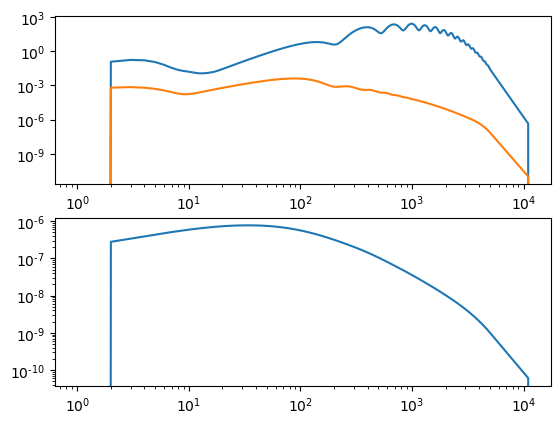

In [7]:
ℓ, CEEℓ, CBBℓ, CΦΦℓ = @sblock let ℓmax = 11000
	ℓ    = 0:ℓmax
	Cℓ   = camb(;r=0.01, ℓmax);
	CBBℓ = Cℓ.tensor.BB(ℓ)
	CEEℓ = Cℓ.unlensed_scalar.EE(ℓ)
	CΦΦℓ = Cℓ.unlensed_scalar.ϕϕ(ℓ)
	for cl in (CEEℓ, CBBℓ, CΦΦℓ)
		cl[.!isfinite.(cl)] .= 0
	end

	return ℓ, CEEℓ, CBBℓ, CΦΦℓ
end

@sblock let hide_plots, ℓ, CEEℓ, CBBℓ, CΦΦℓ
	hide_plots && return
	fig, ax = subplots(2)
	ax[1].plot(ℓ, @. ℓ^2*CEEℓ)
	ax[1].plot(ℓ, @. ℓ^2*CBBℓ)
	ax[2].plot(ℓ, @. ℓ^4*CΦΦℓ)
	ax[1].set_xscale("log")
	ax[2].set_xscale("log")
	ax[1].set_yscale("log")
	ax[2].set_yscale("log")
	return nothing
end

Pixel grid
==============================

Now we don't have pj.freq_mult, pj.θ, ... etc
What is the CMBLensing way to get grid features out of pj?
Are there generic method names that I'm supposed to overload like pix(pj) ...?

In [8]:
# Put these into Proj ...

θ, φ, Ω, freq_mult, Δθ = @sblock let pj, T = Float64, cosθEq=false

    nθ, nφ = pj.Ny, pj.Nx
    θspan = pj.θspan
    φspan = pj.φspan

    @assert Int(2π / φspan[2]) isa Int
    @assert θspan[1] < θspan[2]
    @assert φspan[1] < φspan[2]

    if cosθEq
        znorth = cos.(θspan[1])
        zsouth = cos.(θspan[2])
        θpix∂  = acos.(range(znorth, zsouth, length=nθ+1))
    else
        θpix∂   = T.(θspan[1] .+ (θspan[2] - θspan[1])*(0:nθ)/nθ)
    end
    Δθ = diff(θpix∂)
    θ  = θpix∂[2:end] .- Δθ/2

    freq_mult = Int(2π / φspan[2])
    φ = T.(φspan[1] .+ (φspan[2] - φspan[1])*(0:nφ-1)/nφ)

    Ω  = @. (φ[2] - φ[1]) * abs(cos(θpix∂[1:end-1]) - cos(θpix∂[2:end]))
    θ, φ, Ω, freq_mult, Δθ
end;


@show extrema(@. rad2deg(√Ω)*60)

extrema(#= In[8]:29 =# @__dot__(rad2deg(√Ω) * 60)) = (2.4072362966668, 3.2124059028034764)


(2.4072362966668, 3.2124059028034764)

Plot √Ωpix over ring θ's

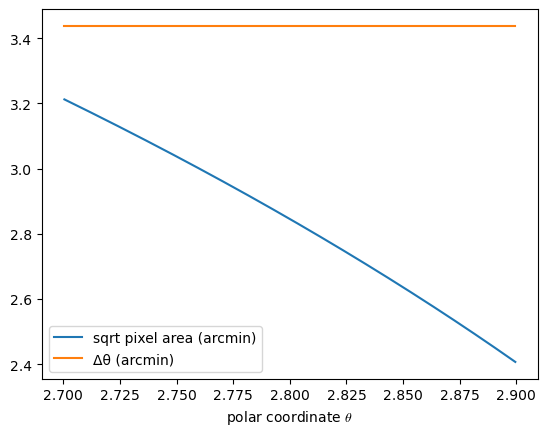

In [9]:
@sblock let θ, φ, Ω, Δθ, hide_plots
    hide_plots && return
    fig,ax = subplots(1)
    ax.plot(θ, (@. rad2deg(√Ω)*60), label="sqrt pixel area (arcmin)")
    ax.plot(θ, (@. rad2deg(Δθ)*60), label="Δθ (arcmin)")
    ax.set_xlabel(L"polar coordinate $\theta$")
    ax.legend()
    return nothing
end

Block diagonal cov matrices
==============================

In [10]:
EB▫, Phi▫  = @sblock let ℓ, CEEℓ, CBBℓ, CΦΦℓ, θ, φ, freq_mult

    nθ, nφ = length(θ), length(φ)
    nφ2π  = nφ*freq_mult
    φ2π   = 2π*(0:nφ2π-1)/nφ2π |> collect

    covβEB   = βcovSpin2(ℓ, CEEℓ, CBBℓ, ngrid=50_000)
    covβPhi  = βcovSpin0(ℓ, CΦΦℓ,       ngrid=50_000)

    ptmW    = FFTW.plan_fft(Vector{ComplexF64}(undef, nφ))
    EBγⱼₖ   = zeros(ComplexF64, nφ)
    EBξⱼₖ   = zeros(ComplexF64, nφ)
    Phiγⱼₖ  = zeros(ComplexF64, nφ)

    T     = ComplexF64 # ComplexF32
    rT    = real(T)
    EB▫   = zeros(T,2nθ,2nθ,nφ÷2+1)
    Phi▫  = zeros(rT,nθ,nθ,nφ÷2+1)

    prgss = Progress(nθ, 1, "EB▫, Phi▫")
    for k = 1:nθ
        for j = 1:nθ
            θ1, θ2 = θ[j], θ[k]
            β      = geoβ.(θ1, θ2, φ2π[1], φ2π)

            covΦΦ̄  = covβPhi(β)
            covPP̄, covPP = covβEB(β)
            covPP̄ .*= multPP̄.(θ1, θ2, φ2π[1], φ2π)
            covPP .*= multPP.(θ1, θ2, φ2π[1], φ2π)

            # periodize and restrict from φ2π to φ
            covΦΦ̄′   = periodize(covΦΦ̄, freq_mult)
            covPP̄′   = periodize(covPP̄, freq_mult)
            covPP′   = periodize(covPP, freq_mult)

            mul!(Phiγⱼₖ,  ptmW, covΦΦ̄′)
            mul!(EBγⱼₖ,   ptmW, covPP̄′)
            mul!(EBξⱼₖ,   ptmW, covPP′)

            @inbounds for ℓ = 1:nφ÷2+1
                Jℓ = Jperm(ℓ, nφ) # ℓ==1 ? 1 : nφ - ℓ + 2
                Phi▫[j,  k,    ℓ] = real(Phiγⱼₖ[ℓ])
                EB▫[j,   k,    ℓ] = EBγⱼₖ[ℓ]
                EB▫[j,   k+nθ, ℓ] = EBξⱼₖ[ℓ]
                EB▫[j+nθ,k,    ℓ] = conj(EBξⱼₖ[Jℓ])
                EB▫[j+nθ,k+nθ, ℓ] = conj(EBγⱼₖ[Jℓ])
            end
        end
        next!(prgss)
    end

    @show Base.summarysize(EB▫) / 1e9
    @show Base.summarysize(Phi▫)  / 1e9

    return EB▫, Phi▫
end;

EB▫, Phi▫100%|██████████████████████████████████████████| Time: 0:01:09


Base.summarysize(EB▫) / 1.0e9 = 0.985600048
Base.summarysize(Phi▫) / 1.0e9 = 0.123200048


In [11]:
EB▫½, Phi▫½ = @sblock let EB▫, Phi▫
    EB▫½  = similar(EB▫)
    Phi▫½ = similar(Phi▫)
    for b in axes(EB▫,3)
        # EB▫½[:,:,b]  .= sqrt(Hermitian(EB▫[:,:,b]))
        # Phi▫½[:,:,b] .= sqrt(Symmetric(Phi▫[:,:,b]))
        # ... or ...
        try
            EB▫½[:,:,b]  .= Matrix(cholesky(Hermitian(EB▫[:,:,b])).L)
            Phi▫½[:,:,b] .= Matrix(cholesky(Symmetric(Phi▫[:,:,b])).L)
        catch
            @show b
            break
        end
    end
    EB▫½, Phi▫½
end;

Test simulation of ϕmap, Qmap, Umap
=======================================

Field sim unit noise

In [12]:
ϕ′ = EquiRectMap(randn(Float64, pj.Ny, pj.Nx), pj)
P′ = EquiRectQUMap(randn(ComplexF64, pj.Ny, pj.Nx), pj)

153600-element 200×768-pixel EquiRectQUMap{Array{ComplexF64, 2}}:
    1.471324987464964 - 0.3676790973829151im
   2.1206260567141078 + 1.5897343907562265im
  0.40050612528839846 + 0.35809873119253416im
  -0.2397357457346255 + 1.1297287450940594im
 -0.47308535117446743 + 0.14706474034068934im
  -0.9021220787689133 + 0.952456891434876im
  0.20180762335950642 + 0.02129752417099018im
 -0.11516124953951538 - 0.13146398596187506im
   0.1442329043549521 - 0.5129118340986888im
  -0.7629167920859764 - 1.580182385807955im
  -0.9342470648409357 - 0.9375120467160972im
   -0.761244642024255 + 0.3431000584309459im
  -0.2868926403282359 - 0.6752924711753366im
                      ⋮
 -0.19149690217286358 - 1.2190190019224425im
   0.6045490189835536 + 1.0876688280232658im
  -0.4936889558956932 - 0.9931509346771963im
   0.8563484890513697 + 0.9594619948102805im
   0.7324977523500882 - 0.17983921458949637im
   1.6763570649780817 - 0.5670630042141018im
   0.6578645262097065 + 0.5162472508631228im
   -1.5

Test conversion

In [13]:
AzFourier(ϕ′)
QUAzFourier(P′)

154000-element 200×768-pixel EquiRectQUAzFourier{Array{ComplexF64, 2}}:
   0.8416633712506152 + 0.6505353562697672im
 -0.06922544392826349 - 0.6802879282882107im
  -0.2666195524403168 + 0.41935699494471074im
  0.07871451025550577 + 0.3172104244621605im
    1.095797824780527 - 0.5780458372356911im
  -1.0032172650557054 + 1.5858342450068836im
  0.09740559381962967 - 0.22089360918949885im
   0.6956509438948562 + 0.17996347520640374im
   0.4800498871580596 + 0.4391600849344618im
   1.1036690816805512 + 0.18606596380299387im
   -0.654932621580876 + 1.4772390595202758im
  -0.4440207701880157 - 1.0678503492590976im
   0.9706916994188218 - 0.012229713791892787im
                      ⋮
  -0.9386876443964942 - 0.30629476597629546im
   0.7652223398584677 + 0.5865906853348797im
   0.9792672635583423 + 0.11625275592724896im
  -1.5537551399437197 - 1.7681293524208936im
   0.4321765256332689 - 0.004093021872743132im
  -0.1104388324691084 - 0.5780290882816823im
  -0.1538781800025144 - 0.6678286306655

generate simulation

In [14]:
ϕsim = tulliomult(Phi▫½,  ϕ′)
Psim = tulliomult(EB▫½, P′)

154000-element 200×768-pixel EquiRectQUAzFourier{Array{ComplexF64, 2}}:
     10.496887465057329 + 8.113215639476163im
      7.690576288450215 + 1.0800233644843926im
       1.79029689787636 - 0.5581964774405992im
    -0.9606343777156557 + 2.8095957812172636im
      5.565707534547427 + 0.3076909173478355im
      3.356413983329592 + 6.279675056809314im
    -2.3331423134345077 + 10.198516030336036im
     1.3767869450261725 + 7.079009238796197im
      7.534823892983826 + 6.24043069291738im
     14.188142933966791 + 6.423231437768244im
      10.48151707139999 + 13.30559072140789im
    0.07070184161718851 + 9.37960559717765im
     1.6010695983057195 + 0.1388391697225005im
                        ⋮
  -0.008797297589709721 - 0.0001975175185737405im
   0.009160300134307494 + 0.0030535540213067307im
     0.0087980023761287 + 0.00236508854639939im
  -0.014366673807030456 - 0.004723621561447936im
 0.00017735306368961423 + 0.0112812336645785im
  0.0010248195808848675 + 0.004855789408154116im
 -0.001

plot

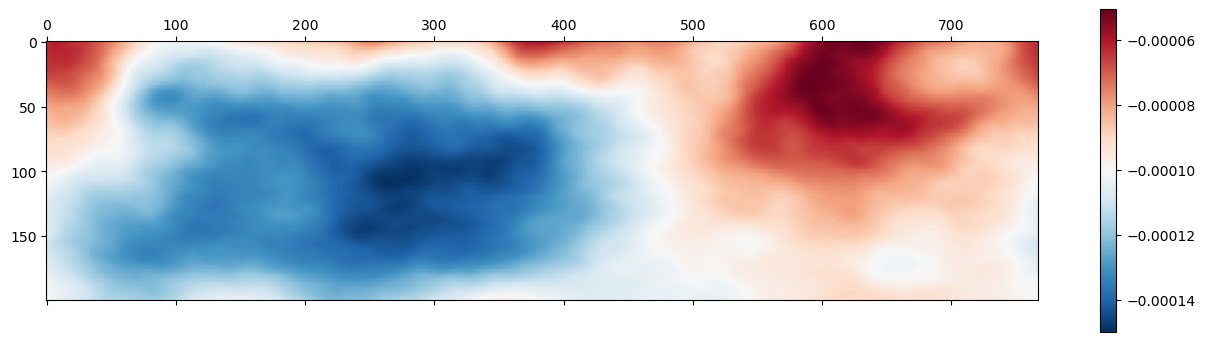

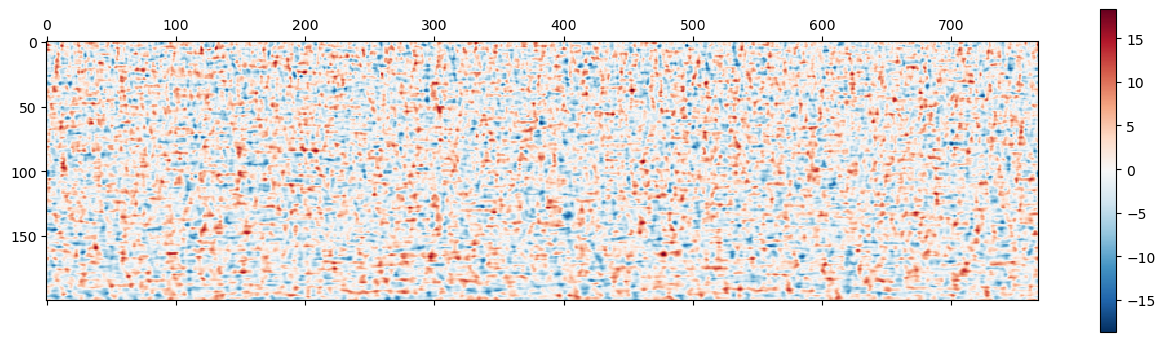

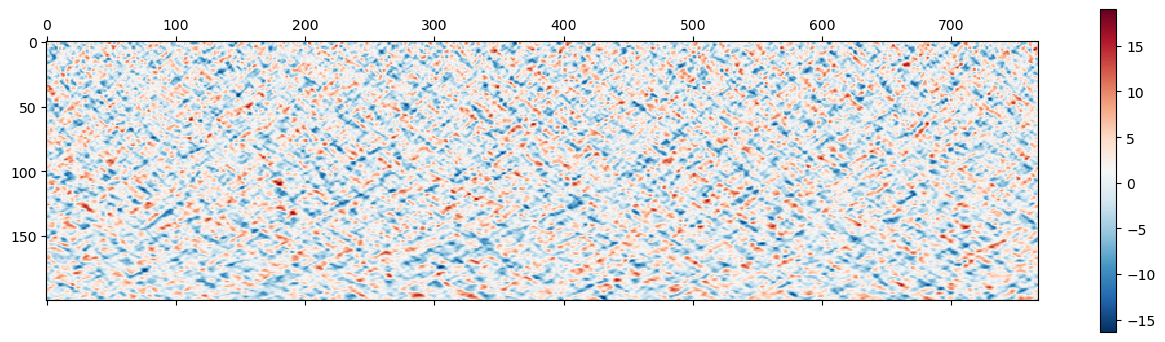

PyObject <matplotlib.colorbar.Colorbar object at 0x7f9629662310>

In [15]:
ϕmap = Map(ϕsim).arr
Qmap = real.(QUMap(Psim).arr)
Umap = imag.(QUMap(Psim).arr)

ϕmap  |> matshow; colorbar()
Qmap  |> matshow; colorbar()
Umap  |> matshow; colorbar()

In [36]:
gradient(x-> dot(Map(x), Map(x)), ϕsim)[1]

77000-element 200×768-pixel EquiRectAzFourier{Array{ComplexF64, 2}}:
  -0.004332104922347933 + 0.0im
  -0.004365976633893371 + 0.0im
 -0.0043993571977144616 + 0.0im
  -0.004431823007688612 + 0.0im
  -0.004463655281400937 + 0.0im
  -0.004495386912805226 + 0.0im
  -0.004526989702643898 + 0.0im
 -0.0045580729959546805 + 0.0im
  -0.004588735973974828 + 0.0im
  -0.004619341640114211 + 0.0im
  -0.004649838089373936 + 0.0im
  -0.004679888083615272 + 0.0im
 -0.0047091922361274284 + 0.0im
                        ⋮
 -1.4889289901847857e-9 + 0.0im
    2.76651996833727e-9 + 0.0im
   2.703715246328024e-9 + 0.0im
  1.3529387881524126e-9 + 0.0im
 -1.5223172931572432e-9 + 0.0im
  1.0929266905190445e-9 + 0.0im
  -5.895221523659184e-9 + 0.0im
 -4.982127356029487e-11 + 0.0im
  -3.248509840061359e-9 + 0.0im
 -6.459690535541145e-10 + 0.0im
  8.846375137920565e-10 + 0.0im
  1.0301847241967604e-9 + 0.0im

TODO:
=======================================
• unitary version (look into later ) 
• Need to make sure the sign of U matches CMBLensing
  ... probably just need a negative spin 2 option in CirculantCov
• Block field operators and all the stuff to go with it

Random Notes
=======================================

 basis conversion:
Is there some guarentee/requirment that the conversion happens within the same Proj?
I guess I'm making it a requirement by the conversion definitions below.

I'm partly confused how the BasisField type and the Proj type interact.
For example, would there ever be a case when one would use RingMapS0
without the corresponding AzEq

Working understanding:
* The field type parameter AzEq <: Proj tells you what the metadata is
* The field type parameter Ring <: Basis tells you what the dual Basis is